# Texas Demographic Segmentation
This project will utilize unsupervised clustering techniques to segment the population of Texas based on census data. Each row in this data represents a census tract, which is more or less the equivalent of a neighborhood. The results of this model are intended to provide value to any entity such as a political campaign or marketing team trying to gain insight into the different segments of Texas' population. 

## Load and Clean the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# get an overview of the data
import pandas_profiling
import seaborn as sns
sns.set(style="white", context="talk")

from sklearn.manifold import TSNE
pd.set_option('display.max_columns', 500)

In [2]:
# load csv
df = pd.read_csv(r'C:\Users\garf\acs2015_census_tract_data.csv')

In [3]:
# trim to texas only, drop state col bc its redundant
texas = df.loc[df['State']=='Texas'].drop(columns=['State'], axis=1)

In [4]:
# dropping redundant columns
# use poverty instead of child pov, use men and women instead of totalpop
# drop census tract and county for analysis, can refer back later to those labels if we need to
# drop redundant income features, keeping income per capita
# drop emplyed and use unemployment pct
# drop citizen and use pct citizen
drop_cols_for_analysis = ['ChildPoverty','CensusTract','County','Income','IncomeErr','IncomePerCapErr', 'Men', 'Women','Employed','Citizen']
tx_dropped = texas.drop(columns=drop_cols_for_analysis, axis=1)

In [5]:
## feature engineer percent male in order to remove some colinearity:
## Men is highly correlated with Employed (ρ = 0.9103626144)
## Women is highly correlated with Men (ρ = 0.9363650965)
tx_dropped['PercentMale'] = texas['Men']  / texas['TotalPop']
## create pct citizen feature
tx_dropped['PercentCitizen'] = texas['Citizen'] / texas['TotalPop']

In [6]:
# pandas_profiling.ProfileReport(tx_dropped)

Only 39 rows have missing values, we'll drop them.

In [7]:
tx_clean = tx_dropped.dropna()

In [8]:
tx_clean.shape

(5207, 28)

In [9]:
tx_dropped.shape

(5265, 28)

## Explore the Data

### Feature Correlations

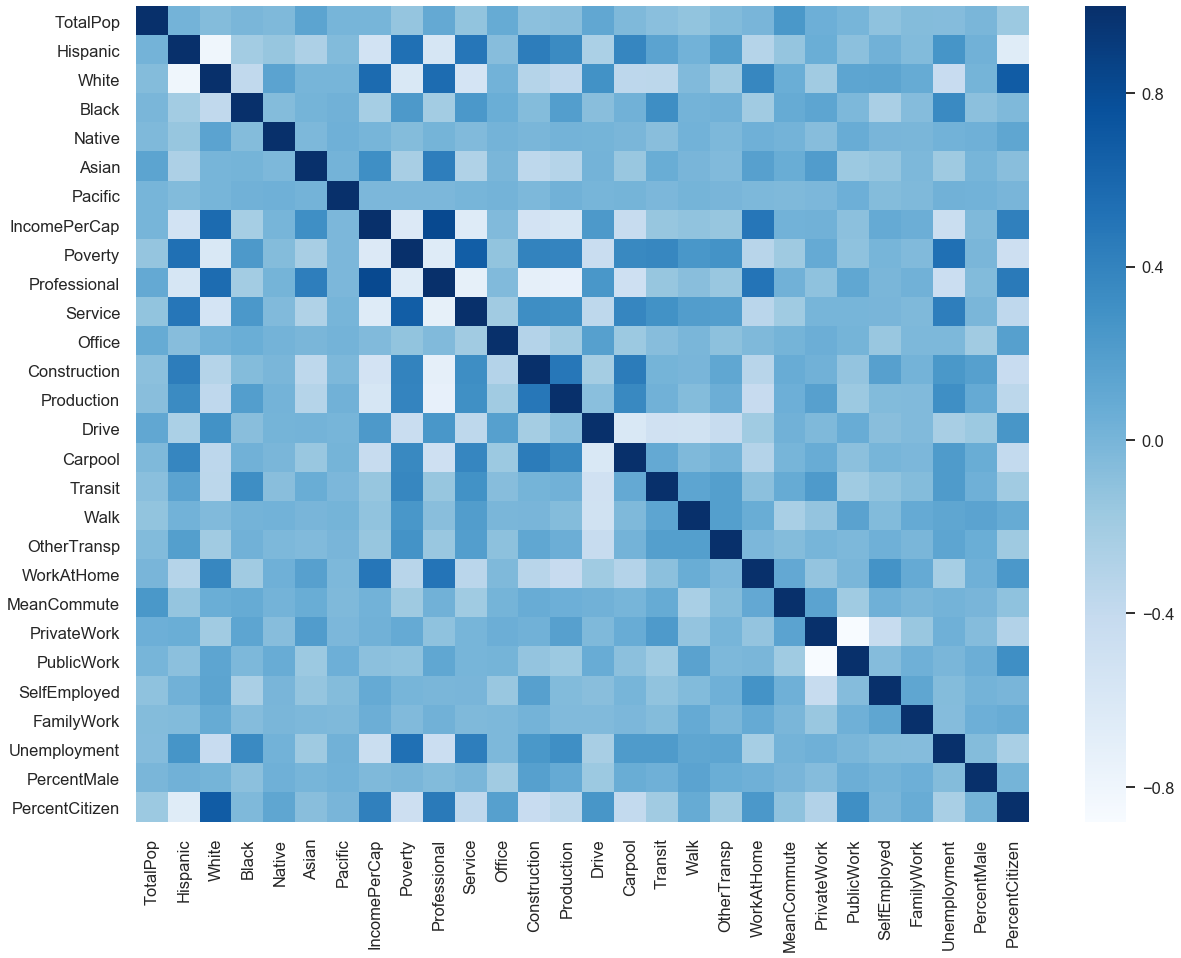

In [10]:
# Correlation heatmap
plt.subplots(figsize=(20,15))
ax = plt.axes()
corr = tx_clean.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           cmap = "Blues")

In [11]:
## list of the top 25 positive correlations
top25_corr_pos = tx_clean.corr().unstack().sort_values(ascending=False).drop_duplicates()
top25_corr_pos.head(25)

PercentCitizen  PercentCitizen    1.000000
Professional    IncomePerCap      0.819460
PercentCitizen  White             0.678600
Poverty         Service           0.664932
IncomePerCap    White             0.567186
White           Professional      0.564453
Hispanic        Poverty           0.534241
Unemployment    Poverty           0.532394
WorkAtHome      Professional      0.503979
                IncomePerCap      0.489172
Hispanic        Service           0.488403
Construction    Production        0.482224
Professional    PercentCitizen    0.465622
Construction    Carpool           0.451402
                Hispanic          0.443888
Professional    Asian             0.441227
Service         Unemployment      0.436180
PercentCitizen  IncomePerCap      0.422563
Poverty         Construction      0.400083
Production      Poverty           0.390822
Hispanic        Carpool           0.379928
Service         Carpool           0.379472
WorkAtHome      White             0.374579
Transit    

In [12]:
## list of the top 25 negative correlations
top25_corr_neg = tx_clean.corr().unstack().sort_values().drop_duplicates()
top25_corr_neg.head(25)

PublicWork      PrivateWork      -0.880064
Hispanic        White            -0.800697
Production      Professional     -0.723183
Service         Professional     -0.714781
Professional    Construction     -0.707921
Hispanic        PercentCitizen   -0.655073
IncomePerCap    Service          -0.643161
Professional    Poverty          -0.640479
Poverty         IncomePerCap     -0.620741
Drive           Carpool          -0.600800
Poverty         White            -0.600172
Production      IncomePerCap     -0.570748
Hispanic        Professional     -0.568425
White           Service          -0.549016
IncomePerCap    Construction     -0.530491
Hispanic        IncomePerCap     -0.522917
Walk            Drive            -0.511070
Drive           Transit          -0.499331
Professional    Carpool          -0.488300
PercentCitizen  Poverty          -0.469355
Professional    Unemployment     -0.457452
IncomePerCap    Unemployment     -0.450585
Drive           Poverty          -0.433009
PercentCiti

### Categories of Features
Let's break down the groups of features in the set.

In [13]:
columns = list(tx_clean.columns)
columns

['TotalPop',
 'Hispanic',
 'White',
 'Black',
 'Native',
 'Asian',
 'Pacific',
 'IncomePerCap',
 'Poverty',
 'Professional',
 'Service',
 'Office',
 'Construction',
 'Production',
 'Drive',
 'Carpool',
 'Transit',
 'Walk',
 'OtherTransp',
 'WorkAtHome',
 'MeanCommute',
 'PrivateWork',
 'PublicWork',
 'SelfEmployed',
 'FamilyWork',
 'Unemployment',
 'PercentMale',
 'PercentCitizen']

#### Ethnicity

In [14]:
ethnic_list = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']

Text(0.5, 1.0, 'Ethnicity in Texas')

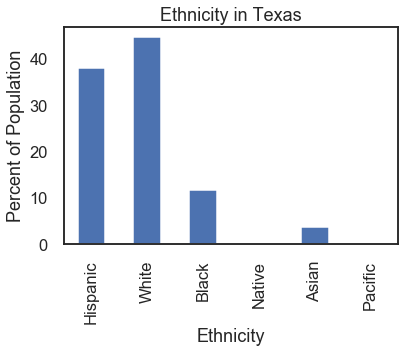

In [15]:
race_plot = tx_clean[ethnic_list].mean().plot(kind="bar")
plt.ylabel('Percent of Population')
plt.xlabel('Ethnicity')
plt.title('Ethnicity in Texas')

#### Gender

In [16]:
# pct male
tx_clean['PercentMale'].mean()

0.4961143262643697

#### Citizenship

In [17]:
# percentage of population that are citizens
tx_clean['PercentCitizen'].mean()

0.6463092981931459

This data show that 65% of the population are citizens, which seems staggeringly low, even for a state with some of the most illegal immigration in the country. We'll need to dive deeper into this category to figure out if something else is going on here.

#### Economic

Text(0.5, 0, 'Dollars')

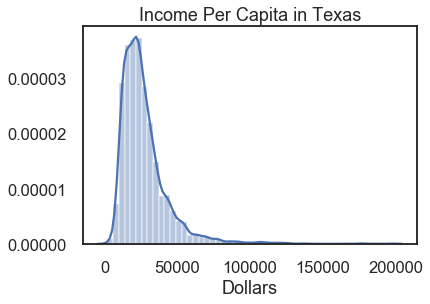

In [18]:
# distribution of income per capita
sns.distplot(tx_clean['IncomePerCap'])
plt.title('Income Per Capita in Texas')
plt.xlabel('Dollars')

In [19]:
tx_clean['IncomePerCap'].mean()

26991.38851545996

It looks like income per capita is not normally distributed, and it's much lower than I expected, at only $27,000

In [20]:
# avg pct poverty 
tx_clean['Poverty'].mean()

18.34127136546956

Text(0.5, 1.0, 'Industry Distribution in Texas')

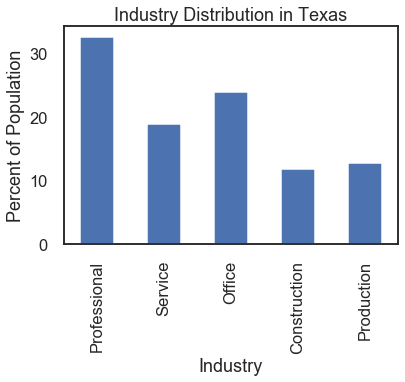

In [21]:
industry_list = ['Professional','Service','Office','Construction','Production']
industry_plot = tx_clean[industry_list].mean().plot(kind="bar")
plt.ylabel('Percent of Population')
plt.xlabel('Industry')
plt.title('Industry Distribution in Texas')

Text(0.5, 1.0, 'Type of Employment in Texas')

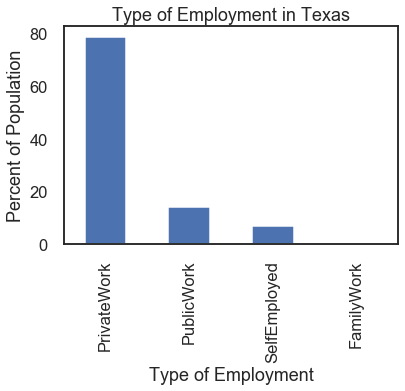

In [22]:
employment_list = ['PrivateWork','PublicWork','SelfEmployed','FamilyWork',]
employment_plot = tx_clean[employment_list].mean().plot(kind="bar")
plt.ylabel('Percent of Population')
plt.xlabel('Type of Employment')
plt.title('Type of Employment in Texas')

#### Transportation

Text(0.5, 1.0, 'Transportation in Texas')

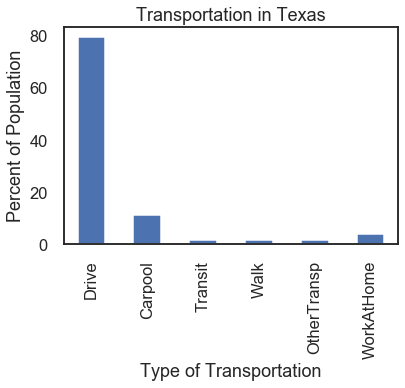

In [23]:
transportation_list = ['Drive','Carpool','Transit','Walk','OtherTransp','WorkAtHome']
transportation_plot = tx_clean[transportation_list].mean().plot(kind="bar")
plt.ylabel('Percent of Population')
plt.xlabel('Type of Transportation')
plt.title('Transportation in Texas')

In [24]:
tx_clean['MeanCommute'].mean()

24.75417706932975

In [25]:
texas['MeanCommute'].loc[texas['County']=='Dallas'].mean()

26.29790874524715

## Start to Cluster
We'll use k means to begin to cluster the data and create segments of the population.

In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

#### Normalize the data

In [27]:
# declare features
X = tx_clean
# # normalize them
# X_norm = normalize(X)

# use min max scaler instead of normalize
scaler = MinMaxScaler(feature_range=[0, 1])
X_scaled = scaler.fit_transform(X)

#### Reduce Dimensionality

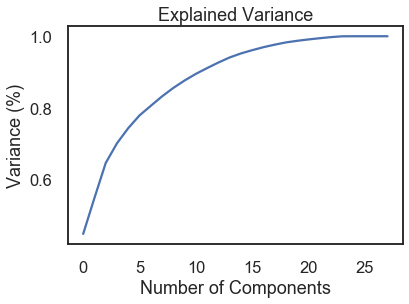

In [28]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_scaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

Around 20 components explain most of the variance.

In [29]:
# select amount of components to keep
X_pca = PCA(20).fit_transform(X_scaled)

#### K means: Find optimal k value

By using the 'elbow graph' method we can identify the best k value to balance the effectiveness between the extremes of 1 cluster and a cluster for each data point. We use the inertia as our metric for the coherency of each cluster. It is calculated using within-cluster sum-of-squares.

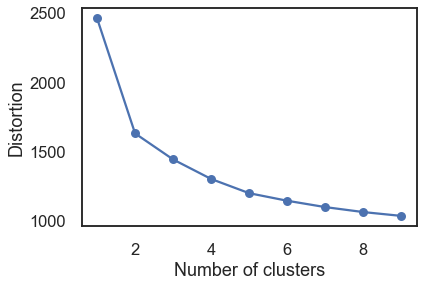

In [30]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 10):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X_pca)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

2 is arguably the optimal number of clusters based on this method, but that doesn't give us much insight. 3 clusters will preserve the usefulness of the model while providing more insight. 

Next I will get the labels for each cluster and add them as a column to our dataframe.

In [31]:
## create k means object
km = KMeans(
        n_clusters=3, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
## fit the model
model = km.fit(X_pca)

In [32]:
## get cluster labels for each row
cluster_labels = model.labels_

In [33]:
tx_clean['Cluster Label'] = cluster_labels

c:\python34\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
## seperate by cluster
cluster_zero = tx_clean.loc[tx_clean['Cluster Label'] == 0]
cluster_one = tx_clean.loc[tx_clean['Cluster Label'] == 1]
cluster_two = tx_clean.loc[tx_clean['Cluster Label'] == 2]

In [35]:
cluster_zero.shape

(1634, 29)

In [36]:
cluster_one.shape

(2355, 29)

In [37]:
cluster_two.shape

(1218, 29)

In [41]:
# group by cluster and take the mean for each column
tx_grouped = tx_clean.groupby(['Cluster Label']).mean()

## Results and Conclusions
Below is the average for each feature for each cluster of neighborhoods.

In [47]:
tx_grouped.head()

,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,IncomePerCap,Poverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,PercentMale,PercentCitizen
Cluster Label,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5071.053244,37.605508,33.224969,23.430049,0.244737,3.580661,0.100857,21140.739902,21.123195,27.101958,21.642044,24.831946,11.853427,14.572032,79.440269,11.777295,2.124908,1.996206,1.820073,2.842289,24.065055,79.602693,14.501775,5.763709,0.133231,8.596267,0.494333,0.642876
1,5097.426327,16.595159,69.982505,6.120382,0.318641,4.936900,0.063652,37372.931635,10.077537,44.360807,13.490998,24.194098,8.656900,9.297452,81.923227,8.632144,0.924076,1.593333,1.396008,5.532909,25.620000,77.491932,14.840297,7.455117,0.211847,5.399066,0.495422,0.721953
2,5090.784893,80.290230,11.137192,6.428407,0.146716,1.337767,0.036207,14767.600164,30.587110,17.529146,25.366749,22.544499,17.812808,16.749672,75.129885,14.986289,2.664943,2.009442,2.632594,2.577668,24.004598,80.301560,12.083415,7.468062,0.150000,9.576026,0.499844,0.504658


#### General Findings
*Keep in mind that each figure represents the average for a neighborhood*

- Since we are dealing with census data its not surprising that race and income were the big deciders in the clusters. 

- Cluster 2 represents a neighborhood that is mostly Hispanic, with a citizenship rate of only 50%, and very high poverty at 30%. However, keep in mind the highest citzenship rate among clusters is only 72%.

- Cluster 1 represents mostly white neighborhoods filled with higher earning professionals. This cluster is nearly as big as the other two clusters combined.

- Cluster 0 is the only one that is somewhat ambiguous. It is close to evenly split among White, Hispanic and Black with every economic category falling between the other two clusters. 
    - This seems to indicate that breaking down this cluster more intimately would result in the most insight among all clusters.

#### Evaluating the model
Since we're using an unsupervised approach on unlabeled data, we can't necessarily evaluate the exact accuracy of the model, or even what that means. However, we can feel very confident that the results are intuitive based on the demographic makeup of Texas.

#### Shortcomings of the Model
First and foremost our data limit us to mostly racial and economic information. This of course could be highly useful, but is more narrow than it could be. Secondly, it is a bird's eye view of Texas, and with only three clusters, only scratches the surface of the different types of neighborhoods that exist in the state. 

#### Moving Forward
The next steps I would take on this project would be to further break down the clusters. In general, a further exploration into the the one cluster that was semi-ambiguous (cluster zero) would provide more immediate insight. However, the other clusters could be broken down further too if they were of more interest to some marketing or political campaign.